## Predictive Model using Random Forest

Random Forest, a ensemble machine learning algorithm with multiple decision trees could be used for classification or regression algorithm, and it has an elegant way of dealing with nonlinear or linear data. 

> Random forest aims to reduce the previously mentioned correlation issue by choosing only a subsample of the feature space at each split. Essentially, it aims to make the trees de-correlated and prune the trees by setting a stopping criteria for node splits, which I will cover in more detail later.


### Important Parameters

* number of estimators: the number of trees for constructing forest.
* max depth of each tree: the number of features per decision tree.
* max features per split: it affects the performance of the whole dicision tree.

estimator also termed tree and depth control the complexity of the model, with larger estimators would result in better and high density forest and maximum depth helps fighting with overfitting. 

Random Forest doesn't require careful preprocessing such as normalization of data. Standardization is an important requirement for many classification models that should be handled when implementing pre-processing. Some models (like neural networks) can perform poorly if pre-processing isn't considered, so the describe() function is a good indicator for standardization. Fortunately, random forest does not require any pre-processing.

### Step1: Importing the libaries

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style("white")

plt.rcParams['figure.figsize'] = (8, 4)

#### Step2: Importing data 

In [17]:
data = pd.read_csv("../../Result/Profile/CRC_HC_species.csv")
data.drop('Unnamed: 0', axis=1, inplace=True)
data = data.set_index('SampleID').sort_values(by='Group', ascending=False)

#### Step3: Transforming the string label into numeric label

The RandomForestClassifier in sklearn does not accept string labels for categorical variables.

* 0 = HC = Healthy Control
* 1 = CRC = Colorectal Cancer

In [18]:
data['Group'] = data['Group'].apply(lambda x: 0 if x == "HC" else 1)
X = data.iloc[:, 1:data.shape[1]].values
y = data.iloc[:, 0].values

le = LabelEncoder()
y = le.fit_transform(y)
y

array([0, 0, 0, ..., 1, 1, 1])

#### Step3: Classification with cross-validation

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)
rfc = RandomForestClassifier(random_state=123)

param_grid = { 
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4, 5, 6, 7, 8],
        'criterion' :['gini', 'entropy']
    }

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

#### Step4: optimal parameters

In [20]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'log2',
 'n_estimators': 500}

In [22]:
rfc_final = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=7, criterion='gini', random_state=123)
rfc_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features='log2', n_estimators=500,
                       random_state=123)

#### Step5: the performance of model

In [23]:
classifier_score = rfc_final.score(X_test, y_test)
print('\nThe classifier accuracy score is {:03.2f}\n'.format(classifier_score))


The classifier accuracy score is 0.70



In [26]:
predicted = rfc_final.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

#print(f'Out-of-bag score estimate: {rfc_final.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Mean accuracy score: 0.698


#### Step6: Final prediction 

<AxesSubplot:>

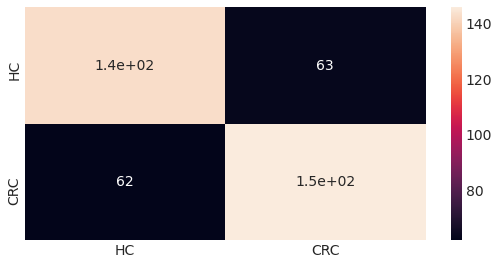

In [36]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=['HC', 'CRC'], index=['HC', 'CRC'])
sns.heatmap(cm, annot=True)

In [45]:
result = pd.DataFrame(y_test, columns=["Actual"])
result['Predicted'] = predicted
result

,Actual,Predicted
0,0,1
1,0,0
2,1,0
3,1,0
4,1,1
...,...,...
409,0,0
410,0,0
411,1,1
412,1,1


## Random Forset in python from Kaggle

> Random forests, also known as random decision forests, are a popular ensemble method that can be used to build predictive models for both classification and regression problems. Ensemble methods use multiple learning models to gain better predictive results — in the case of a random forest, the model creates an entire forest of random uncorrelated decision trees to arrive at the best possible answer.

In [48]:
%matplotlib inline

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from urllib.request import urlopen 

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500) 

### Load data 

In [55]:
data = pd.read_csv("../../Result/Profile/CRC_HC_species.csv")
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,SampleID,Group,Faecalibacterium_prausnitzii,Streptococcus_salivarius,Anaerostipes_hadrus,Bacteroides_stercoris,Collinsella_aerofaciens,Bifidobacterium_longum,Bacteroides_plebeius,Bacteroides_vulgatus,Dorea_longicatena,Fusicatenibacter_saccharivorans,Coprococcus_comes,Ruminococcus_torques,Eubacterium_hallii,Bacteroides_uniformis,Blautia_wexlerae,Gemmiger_formicilis,Dorea_formicigenerans,Streptococcus_parasanguinis,Ruminococcus_lactaris,Coprococcus_catus,Roseburia_intestinalis,Roseburia_inulinivorans,Eubacterium_rectale,Blautia_obeum,Agathobaculum_butyriciproducens,Bacteroides_xylanisolvens,Bacteroides_ovatus,Bacteroides_thetaiotaomicron,Streptococcus_thermophilus,Eubacterium_ramulus,Bifidobacterium_adolescentis,Eubacterium_ventriosum,Flavonifractor_plautii,Gemella_sanguinis,Streptococcus_infantis,Streptococcus_mitis,Rothia_mucilaginosa,Oscillibacter_sp_57_20,Roseburia_hominis,Haemophilus_parainfluenzae,Roseburia_sp_CAG_471,Actinomyces_odontolyticus,Alistipes_finegoldii,Alistipes_putredinis,Veillonella_atypica,Ruminococcus_bromii,Firmicutes_bacterium_CAG_83,Veillonella_dispar,Veillonella_parvula,Eubacterium_eligens,Holdemania_filiformis,Streptococcus_oralis,Collinsella_intestinalis,Enorma_massiliensis,Ruminococcus_gnavus,Bacteroides_eggerthii,Roseburia_faecis,Asaccharobacter_celatus,Gordonibacter_pamelaeae,Eubacterium_sp_CAG_180,Parabacteroides_merdae,Bacteroides_dorei,Eubacterium_siraeum,Barnesiella_intestinihominis,Firmicutes_bacterium_CAG_145,Bacteroides_cellulosilyticus,Adlercreutzia_equolifaciens,Ruminococcus_bicirculans,Firmicutes_bacterium_CAG_110,Parabacteroides_distasonis,Ruthenibacterium_lactatiformans,Anaeromassilibacillus_sp_An250,Odoribacter_splanchnicus,Oscillibacter_sp_CAG_241,Alistipes_shahii,Actinomyces_sp_ICM47,Eggerthella_lenta,Escherichia_coli,Butyricimonas_virosa,Enterorhabdus_caecimuris,Intestinibacter_bartlettii,Clostridium_leptum,Erysipelatoclostridium_ramosum,Slackia_isoflavoniconvertens,Clostridium_innocuum,Clostridium_sp_CAG_58,Bilophila_wadsworthia,Akkermansia_muciniphila,Bifidobacterium_pseudocatenulatum,Eubacterium_sp_CAG_38,Bacteroides_fragilis,Blautia_sp_CAG_257,Intestinimonas_butyriciproducens,Parasutterella_excrementihominis,Alistipes_indistinctus,Clostridium_citroniae,Lawsonibacter_asaccharolyticus,Hungatella_hathewayi,Eisenbergiella_tayi,Paraprevotella_xylaniphila,Clostridium_bolteae,Anaerotruncus_colihominis,Bacteroides_caccae,Mogibacterium_diversum,Clostridium_symbiosum,Lachnospira_pectinoschiza,Prevotella_copri,Bacteroides_massiliensis,Phascolarctobacterium_faecium,Butyricimonas_synergistica
0,SID31004,CRC,0.135886,0.110076,0.082626,0.052196,0.045848,0.039128,0.037739,0.037588,0.037230,0.035802,0.026993,0.025000,0.023365,0.021166,0.020716,0.020334,0.019404,0.018909,0.014253,0.010716,0.010495,0.008203,0.007249,0.006702,0.006095,0.005961,0.005191,0.004916,0.004524,0.004189,0.003483,0.002377,0.002207,0.001895,0.001708,0.001172,0.001107,0.000761,0.000692,0.000682,0.000654,0.000645,0.000615,0.000452,0.000321,0.000309,0.000286,0.000283,0.000279,0.000247,0.000176,0.000112,0.000100,0.000081,0.000081,0.000051,0.000051,0.000018,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,SID31009,HC,0.051831,0.001390,0.075518,0.000000,0.036852,0.023695,0.000000,0.000078,0.044709,0.052743,0.034104,0.009745,0.029710,0.043339,0.001567,0.002313,0.007407,0.000751,0.010141,0.020380,0.010629,0.004704,0.003139,0.011924,0.001074,0.000906,0.000003,0.008357,0.078917,0.002651,0.021771,0.000985,0.000145,0.000026,0.000000,0.000007,0.000086,0.000170,0.000569,0.000000,0.007968,0.000000,0.000681,0.004250,0.000019,0.069477,0.000722

### Cleaning
* 0 = HC = Healthy Control
* 1 = CRC = Colorectal Cancer

In [56]:
data.set_index(['SampleID'], inplace=True)
data['Group'] = data['Group'].map({'HC':0, 'CRC':1})
data.head()

,Group,Faecalibacterium_prausnitzii,Streptococcus_salivarius,Anaerostipes_hadrus,Bacteroides_stercoris,Collinsella_aerofaciens,Bifidobacterium_longum,Bacteroides_plebeius,Bacteroides_vulgatus,Dorea_longicatena,Fusicatenibacter_saccharivorans,Coprococcus_comes,Ruminococcus_torques,Eubacterium_hallii,Bacteroides_uniformis,Blautia_wexlerae,Gemmiger_formicilis,Dorea_formicigenerans,Streptococcus_parasanguinis,Ruminococcus_lactaris,Coprococcus_catus,Roseburia_intestinalis,Roseburia_inulinivorans,Eubacterium_rectale,Blautia_obeum,Agathobaculum_butyriciproducens,Bacteroides_xylanisolvens,Bacteroides_ovatus,Bacteroides_thetaiotaomicron,Streptococcus_thermophilus,Eubacterium_ramulus,Bifidobacterium_adolescentis,Eubacterium_ventriosum,Flavonifractor_plautii,Gemella_sanguinis,Streptococcus_infantis,Streptococcus_mitis,Rothia_mucilaginosa,Oscillibacter_sp_57_20,Roseburia_hominis,Haemophilus_parainfluenzae,Roseburia_sp_CAG_471,Actinomyces_odontolyticus,Alistipes_finegoldii,Alistipes_putredinis,Veillonella_atypica,Ruminococcus_bromii,Firmicutes_bacterium_CAG_83,Veillonella_dispar,Veillonella_parvula,Eubacterium_eligens,Holdemania_filiformis,Streptococcus_oralis,Collinsella_intestinalis,Enorma_massiliensis,Ruminococcus_gnavus,Bacteroides_eggerthii,Roseburia_faecis,Asaccharobacter_celatus,Gordonibacter_pamelaeae,Eubacterium_sp_CAG_180,Parabacteroides_merdae,Bacteroides_dorei,Eubacterium_siraeum,Barnesiella_intestinihominis,Firmicutes_bacterium_CAG_145,Bacteroides_cellulosilyticus,Adlercreutzia_equolifaciens,Ruminococcus_bicirculans,Firmicutes_bacterium_CAG_110,Parabacteroides_distasonis,Ruthenibacterium_lactatiformans,Anaeromassilibacillus_sp_An250,Odoribacter_splanchnicus,Oscillibacter_sp_CAG_241,Alistipes_shahii,Actinomyces_sp_ICM47,Eggerthella_lenta,Escherichia_coli,Butyricimonas_virosa,Enterorhabdus_caecimuris,Intestinibacter_bartlettii,Clostridium_leptum,Erysipelatoclostridium_ramosum,Slackia_isoflavoniconvertens,Clostridium_innocuum,Clostridium_sp_CAG_58,Bilophila_wadsworthia,Akkermansia_muciniphila,Bifidobacterium_pseudocatenulatum,Eubacterium_sp_CAG_38,Bacteroides_fragilis,Blautia_sp_CAG_257,Intestinimonas_butyriciproducens,Parasutterella_excrementihominis,Alistipes_indistinctus,Clostridium_citroniae,Lawsonibacter_asaccharolyticus,Hungatella_hathewayi,Eisenbergiella_tayi,Paraprevotella_xylaniphila,Clostridium_bolteae,Anaerotruncus_colihominis,Bacteroides_caccae,Mogibacterium_diversum,Clostridium_symbiosum,Lachnospira_pectinoschiza,Prevotella_copri,Bacteroides_massiliensis,Phascolarctobacterium_faecium,Butyricimonas_synergistica
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SID31004,1,0.135886,0.110076,0.082626,0.052196,0.045848,0.039128,0.037739,0.037588,0.037230,0.035802,0.026993,0.025000,0.023365,0.021166,0.020716,0.020334,0.019404,0.018909,0.014253,0.010716,0.010495,0.008203,0.007249,0.006702,0.006095,0.005961,0.005191,0.004916,0.004524,0.004189,0.003483,0.002377,0.002207,0.001895,0.001708,0.001172,0.001107,0.000761,0.000692,0.000682,0.000654,0.000645,0.000615,0.000452,0.000321,0.000309,0.000286,0.000283,0.000279,0.000247,0.000176,0.000112,0.000100,0.000081,0.000081,0.000051,0.000051,0.000018,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
SID31009,0,0.051831,0.001390,0.075518,0.000000,0.036852,0.023695,0.000000,0.000078,0.044709,0.052743,0.034104,0.009745,0.029710,0.043339,0.001567,0.002313,0.007407,0.000751,0.010141,0.020380,0.010629,0.004704,0.003139,0.011924,0.001074,0.000906,0.000003,0.008357,0.078917,0.002651,0.021771,0.000985,0.000145,0.000026,0.000000,0.0

### Missing values or Occurrence

In [61]:
data.apply(lambda x: x.isnull().sum(), axis=0)
#data.apply(lambda x: sum(x!=0)/len(x), axis=0)

Group                            0
Faecalibacterium_prausnitzii     0
Streptococcus_salivarius         0
Anaerostipes_hadrus              0
Bacteroides_stercoris            0
                                ..
Lachnospira_pectinoschiza        0
Prevotella_copri                 0
Bacteroides_massiliensis         0
Phascolarctobacterium_faecium    0
Butyricimonas_synergistica       0
Length: 111, dtype: int64

In [62]:
print("Here's the dimensions of our data frame:\n", 
     data.shape)
print("Here's the data types of our columns:\n",
     data.dtypes)

Here's the dimensions of our data frame:
 (1380, 111)
Here's the data types of our columns:
 Group                              int64
Faecalibacterium_prausnitzii     float64
Streptococcus_salivarius         float64
Anaerostipes_hadrus              float64
Bacteroides_stercoris            float64
                                  ...   
Lachnospira_pectinoschiza        float64
Prevotella_copri                 float64
Bacteroides_massiliensis         float64
Phascolarctobacterium_faecium    float64
Butyricimonas_synergistica       float64
Length: 111, dtype: object


### Class balance

In [63]:
def print_dx_perc(data_frame, col):
    '''
    Class distribution for Group
    '''
    try:
        col_vals = data_frame[col].value_counts()
        col_vals = col_vals.reset_index()
        if len(col_vals['index']) > 20:
            print('Warning: values in column are more than 20 \nPlease try a column with lower value counts!')
        else:
            f = lambda x, y: 100 * (x / sum(y))
            for i in range(0, len(col_vals['index'])):
                print('{0} accounts for {1:.2f}% of the {2} column'\
                      .format(col_vals['index'][i], f(col_vals[col].iloc[i], col_vals[col]), col))
    except KeyError as e:
        print('{0}: Not found'.format(e))
        print('Please choose the right column name!')

print_dx_perc(data, 'Group')

1 accounts for 50.22% of the Group column
0 accounts for 49.78% of the Group column


In [66]:
data.describe()

,Group,Faecalibacterium_prausnitzii,Streptococcus_salivarius,Anaerostipes_hadrus,Bacteroides_stercoris,Collinsella_aerofaciens,Bifidobacterium_longum,Bacteroides_plebeius,Bacteroides_vulgatus,Dorea_longicatena,Fusicatenibacter_saccharivorans,Coprococcus_comes,Ruminococcus_torques,Eubacterium_hallii,Bacteroides_uniformis,Blautia_wexlerae,Gemmiger_formicilis,Dorea_formicigenerans,Streptococcus_parasanguinis,Ruminococcus_lactaris,Coprococcus_catus,Roseburia_intestinalis,Roseburia_inulinivorans,Eubacterium_rectale,Blautia_obeum,Agathobaculum_butyriciproducens,Bacteroides_xylanisolvens,Bacteroides_ovatus,Bacteroides_thetaiotaomicron,Streptococcus_thermophilus,Eubacterium_ramulus,Bifidobacterium_adolescentis,Eubacterium_ventriosum,Flavonifractor_plautii,Gemella_sanguinis,Streptococcus_infantis,Streptococcus_mitis,Rothia_mucilaginosa,Oscillibacter_sp_57_20,Roseburia_hominis,Haemophilus_parainfluenzae,Roseburia_sp_CAG_471,Actinomyces_odontolyticus,Alistipes_finegoldii,Alistipes_putredinis,Veillonella_atypica,Ruminococcus_bromii,Firmicutes_bacterium_CAG_83,Veillonella_dispar,Veillonella_parvula,Eubacterium_eligens,Holdemania_filiformis,Streptococcus_oralis,Collinsella_intestinalis,Enorma_massiliensis,Ruminococcus_gnavus,Bacteroides_eggerthii,Roseburia_faecis,Asaccharobacter_celatus,Gordonibacter_pamelaeae,Eubacterium_sp_CAG_180,Parabacteroides_merdae,Bacteroides_dorei,Eubacterium_siraeum,Barnesiella_intestinihominis,Firmicutes_bacterium_CAG_145,Bacteroides_cellulosilyticus,Adlercreutzia_equolifaciens,Ruminococcus_bicirculans,Firmicutes_bacterium_CAG_110,Parabacteroides_distasonis,Ruthenibacterium_lactatiformans,Anaeromassilibacillus_sp_An250,Odoribacter_splanchnicus,Oscillibacter_sp_CAG_241,Alistipes_shahii,Actinomyces_sp_ICM47,Eggerthella_lenta,Escherichia_coli,Butyricimonas_virosa,Enterorhabdus_caecimuris,Intestinibacter_bartlettii,Clostridium_leptum,Erysipelatoclostridium_ramosum,Slackia_isoflavoniconvertens,Clostridium_innocuum,Clostridium_sp_CAG_58,Bilophila_wadsworthia,Akkermansia_muciniphila,Bifidobacterium_pseudocatenulatum,Eubacterium_sp_CAG_38,Bacteroides_fragilis,Blautia_sp_CAG_257,Intestinimonas_butyriciproducens,Parasutterella_excrementihominis,Alistipes_indistinctus,Clostridium_citroniae,Lawsonibacter_asaccharolyticus,Hungatella_hathewayi,Eisenbergiella_tayi,Paraprevotella_xylaniphila,Clostridium_bolteae,Anaerotruncus_colihominis,Bacteroides_caccae,Mogibacterium_diversum,Clostridium_symbiosum,Lachnospira_pectinoschiza,Prevotella_copri,Bacteroides_massiliensis,Phascolarctobacterium_faecium,Butyricimonas_synergistica
count,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000
mean,0.502174,0.050530,0.005438,0.015608,0.021787,0.019118,0.015341,0.024041,0.068395,0.009911,0

### Creating Training and Test Sets

In [70]:
feature_space = data.iloc[:, data.columns != 'Group']
feature_class = data.iloc[:, data.columns == 'Group']


training_set, test_set, class_set, test_class_set = train_test_split(feature_space,
                                                                     feature_class,
                                                                     test_size = 0.20, 
                                                                     random_state = 42)
# Cleaning test sets to avoid future warning messages
class_set = class_set.values.ravel() 
test_class_set = test_class_set.values.ravel() 

### Fitting Random Forest

* n_estimators: The number of decision tree
* max_depth: The maximum splits for all trees in the forest. bootstrap: An indicator of whether or not we want to use bootstrap samples when building trees.
* max_features: The maximum number of features that will be used in node splitting. 
* criterion: This is the metric used to asses the stopping criteria for the decision trees.

In [83]:
fit_rf = RandomForestClassifier(random_state=42)

### Hyperparameters Optimization 

In [84]:
np.random.seed(42)
start = time.time()

param_dist = { 
        #'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'max_depth': [2, 3, 4],
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False]}

cv_rf = GridSearchCV(fit_rf, 
                     cv=10, 
                     param_grid=param_dist, 
                     n_jobs=3)

cv_rf.fit(training_set, class_set)

print('Best Parameters using grid search: \n', cv_rf.best_params_)

end = time.time()

print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None}
Time taken in grid search:  191.25


In [85]:
fit_rf.set_params(criterion = 'entropy',
                  max_features = None, 
                  max_depth = 4)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features=None,
                       random_state=42)

### Out of Bag Error Rate
> Another useful feature of random forest is the concept of an out-of-bag (OOB) error rate. Because only two-thirds of the data are used to train each tree when building the forest, one-third of unseen data can be used in a way that is advantageous to our accuracy metrics without being as computationally expensive as something like cross validation, for instance.

In [86]:
fit_rf.set_params(warm_start=True, 
                  oob_score=True)

min_estimators = 15
max_estimators = 1000

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    fit_rf.set_params(n_estimators = i)
    fit_rf.fit(training_set, class_set)
    
    oob_error = 1 - fit_rf.oob_score_
    error_rate[i] = oob_error

/disk/share/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/disk/share/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/disk/share/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/disk/share/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/disk/share/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs 

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

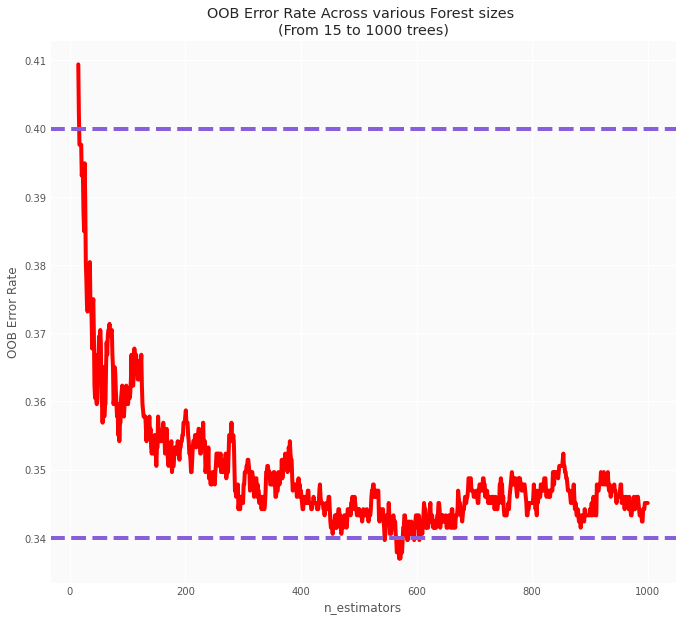

In [90]:
oob_series = pd.Series(error_rate)

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',
                color = 'red')
plt.axhline(0.4, 
            color='#875FDB',
           linestyle='--')
plt.axhline(0.34, 
            color='#875FDB',
           linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

In [95]:
print('OOB Error rate for 400 trees is: {0:.5f}'.format(oob_series[500]))

OOB Error rate for 400 trees is: 0.34330


### Traditional Training and Test Set Split 

In [96]:
fit_rf.set_params(n_estimators=500,
                  bootstrap = True,
                  warm_start=False, 
                  oob_score=False)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features=None,
                       n_estimators=500, random_state=42)

### Training Algorithm
Next we train the algorithm utilizing the training and target class set we had made earlier.

In [97]:
fit_rf.fit(training_set, class_set)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features=None,
                       n_estimators=500, random_state=42)

### Variable Importance

In [98]:
def variable_importance(fit):
    """
    Purpose
    ----------
    Checks if model is fitted CART model then produces variable importance
    and respective indices in dictionary.

    Parameters
    ----------
    * fit:  Fitted model containing the attribute feature_importances_

    Returns
    ----------
    Dictionary containing arrays with importance score and index of columns
    ordered in descending order of importance.
    """
    try:
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Captures whether the model has been trained
        if not vars(fit)["estimators_"]:
            return print("Model does not appear to be trained.")
    except KeyError:
        print("Model entered does not contain 'estimators_' attribute.")

    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [99]:
var_imp_rf = variable_importance(fit_rf)

importances_rf = var_imp_rf['importance']

indices_rf = var_imp_rf['index']

In [100]:
def print_var_importance(importance, indices, name_index):
    """
    Purpose
    ----------
    Prints dependent variable names ordered from largest to smallest
    based on information gain for CART model.
    Parameters
    ----------
    * importance: Array returned from feature_importances_ for CART
                models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest
                based on feature_importances_
    * name_index: Name of columns included in model

    Returns
    ----------
    Prints feature importance in descending order
    """
    print("Feature ranking:")

    for f in range(0, indices.shape[0]):
        i = f
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}"
              .format(f + 1,
                      names_index[indices[i]],
                      importance[indices[f]]))

In [104]:
names_index = data.columns[1:]
print_var_importance(importances_rf, indices_rf, names_index)

Feature ranking:
1. The feature 'Clostridium_symbiosum' has a Mean Decrease in Impurity of 0.05843
2. The feature 'Ruthenibacterium_lactatiformans' has a Mean Decrease in Impurity of 0.04899
3. The feature 'Mogibacterium_diversum' has a Mean Decrease in Impurity of 0.04184
4. The feature 'Roseburia_intestinalis' has a Mean Decrease in Impurity of 0.03830
5. The feature 'Eisenbergiella_tayi' has a Mean Decrease in Impurity of 0.03719
6. The feature 'Faecalibacterium_prausnitzii' has a Mean Decrease in Impurity of 0.03524
7. The feature 'Butyricimonas_virosa' has a Mean Decrease in Impurity of 0.02889
8. The feature 'Eubacterium_eligens' has a Mean Decrease in Impurity of 0.02243
9. The feature 'Asaccharobacter_celatus' has a Mean Decrease in Impurity of 0.02159
10. The feature 'Anaerotruncus_colihominis' has a Mean Decrease in Impurity of 0.02004
11. The feature 'Odoribacter_splanchnicus' has a Mean Decrease in Impurity of 0.01923
12. The feature 'Streptococcus_oralis' has a Mean Decrea

In [105]:
def variable_importance_plot(importance, indices, name_index):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart
    was transposed and index would be in incorrect order.

    Parameters
    ----------
    * importance: Array returned from feature_importances_ for CART
                models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest
                based on feature_importances_
    * name_index: Name of columns included in model

    Returns:
    ----------
    Returns variable importance plot in descending order
    """
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.set_axis_bgcolor('#fafafa')
    plt.title('Feature importances for Random Forest Model\
    \nBreast Cancer (Diagnostic)')
    plt.barh(index,
             importance_desc,
             align="center",
             color = '#875FDB')
    plt.yticks(index,
               feature_space)

    plt.ylim(-1, 30)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean Decrease in Impurity')
    plt.ylabel('Feature')

    plt.show()
    plt.close()

AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

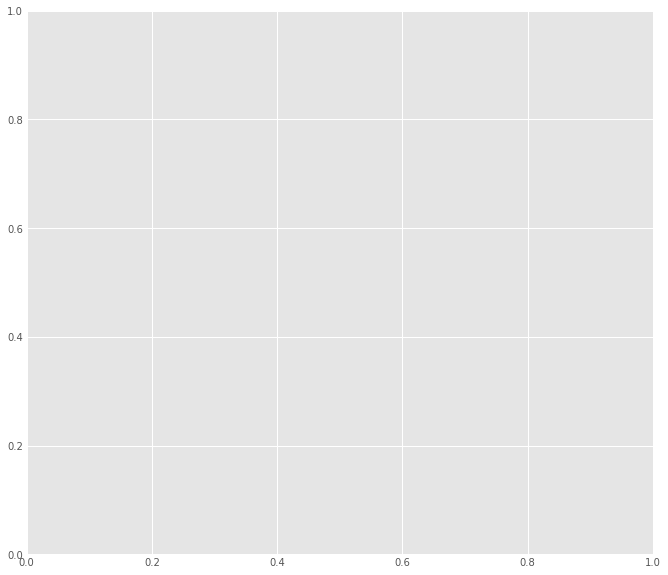

In [106]:
variable_importance_plot(importances_rf, indices_rf, names_index)

### Reference 

1. [Random Forest in Python](https://www.kaggle.com/raviolli77/random-forest-in-python)